In [19]:
import os
import glob
import h5py       
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["image.origin"] = "lower"  

In [20]:
DATA_DIR = r"C:\Work\College\DeepONets\wave_first"

PATTERN = "*.mat"

mat_files = sorted(glob.glob(os.path.join(DATA_DIR, PATTERN)))

file = mat_files[0]


In [21]:
with h5py.File(file, "r") as f:
    top_keys = list(f.keys())
    print(top_keys)
    
    for key in ["t_out", "x", "U_out"]:
        if key in f:
            dset = f[key]
            print(f"{key}: shape={dset.shape}, dtype={dset.dtype}")
        else:
            print(f"{key} not found at top level.")


['U_out', 't_out', 'x']
t_out: shape=(8276, 1), dtype=float64
x: shape=(5120, 1), dtype=float64
U_out: shape=(5120, 8276), dtype=[('real', '<f8'), ('imag', '<f8')]


In [22]:
def loader(filepath, t_key="t_out", x_key="x", U_key="U_out"):
    with h5py.File(filepath, "r") as f:
        t = np.array(f[t_key]).squeeze()
        x = np.array(f[x_key]).squeeze()
        U_raw = np.array(f[U_key])

        if U_raw.dtype.names is not None and 'real' in U_raw.dtype.names:
            U_complex = U_raw['real'] + 1j * U_raw['imag']
            U = np.abs(U_complex)**2
        else:
            U = np.abs(U_raw)**2

        T, X = np.meshgrid(t, x, indexing='ij')
        
        if U.shape != T.shape:
            U = U.T

        output = np.column_stack([T.ravel(), X.ravel(), U.ravel()])

    return output

In [23]:
output = loader("C:\Work\College\DeepONets\wave_first\Re_78315_case3_1of160.mat")


In [24]:
t = output[:, 0]
x = output[:, 1]
U_sq = output[:, 2]

mask = (t > 200) & (x > 150) & (x < 650)

t = t[mask]
x = x[mask]
U_sq = U_sq[mask]

print(t.shape)
print(x.shape)
print(U_sq.shape)

(21951138,)
(21951138,)
(21951138,)


In [25]:
# Load one recording and compute envelope magnitude |U|
print("\nLoaded example recording:")
print("  • t shape:", t.shape)
print("  • x shape:", x.shape)
print("  • U shape:", U_sq.shape, "dtype:", U_sq.dtype)

if t[0] > t[-1]:
    idx = np.argsort(t)
    t = t[idx]
    U = U_sq[idx, :]

# Envelope amplitude
A = np.abs(U_sq)

print("\nEnvelope |U|^2 statistics for this recording:")
print("  • shape:", A.shape)
print("  • min:", A.min())
print("  • max:", A.max())
print("  • mean:", A.mean())
print("  • std :", A.std())



Loaded example recording:
  • t shape: (21951138,)
  • x shape: (21951138,)
  • U shape: (21951138,) dtype: float64

Envelope |U|^2 statistics for this recording:
  • shape: (21951138,)
  • min: 7.35165480908569e-10
  • max: 0.0665647067048186
  • mean: 0.0029885927128468354
  • std : 0.0034396918653974815


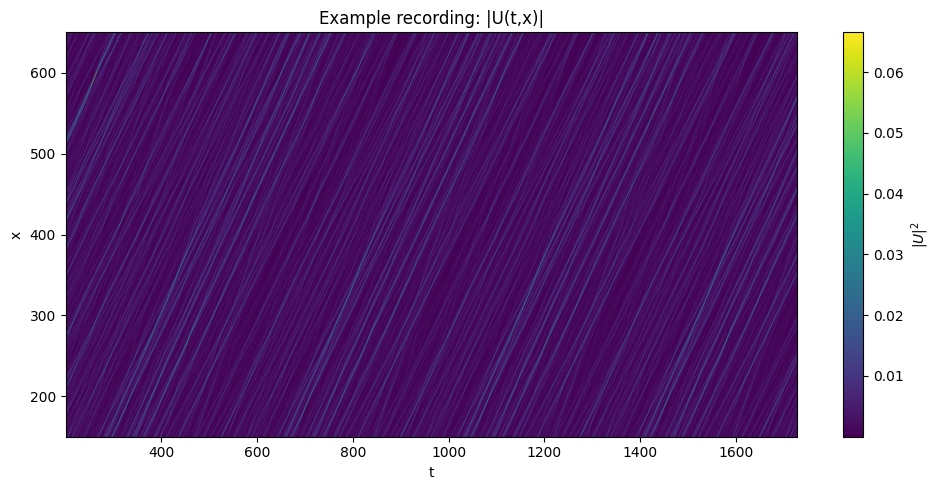

In [26]:
def plot_envelope_heatmap(t, x, A, title="|U(x,t)|^2"):
    # 1. Recover the grid axes from the 1D masked data
    t_vals = np.unique(t)
    x_vals = np.unique(x)
    
    Nt = len(t_vals)
    Nx = len(x_vals)
    
    # 2. Reshape 1D data back into a 2D Matrix (Time x Space)
    # We reshape to (Nt, Nx) then Transpose (.T) so Space is on the Y-axis
    try:
        A_grid = A.reshape(Nt, Nx).T
    except ValueError:
        print(f"Error: Cannot reshape data of length {len(A)} into grid {Nt}x{Nx}")
        return

    # 3. Plot
    plt.figure(figsize=(10, 5))
    
    plt.imshow(
        A_grid,
        origin="lower",
        aspect="auto",
        extent=[t_vals[0], t_vals[-1], x_vals[0], x_vals[-1]],
        cmap='viridis'
    )

    plt.colorbar(label=r"$|U|^2$")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Run it
plot_envelope_heatmap(t, x, A, title="Example recording: |U(t,x)|")

In [27]:
Nx = np.sum(t == t[0])
indices = np.arange(len(t))

t_idx = indices // Nx  
x_idx = indices % Nx  

mask_train_pattern = (t_idx % 2 != 0) & (x_idx % 2 != 0)
mask_test_pattern = (t_idx % 2 == 0) & (x_idx % 2 == 0)

t_train, x_train, U_train = t[mask_train_pattern], x[mask_train_pattern], U_sq[mask_train_pattern]
t_test,  x_test,  U_test  = t[mask_test_pattern],  x[mask_test_pattern],  U_sq[mask_test_pattern]

print(f"Train samples: {len(t_train)}")
print(f"Test samples:  {len(t_test)}")

Train samples: 5486138
Test samples:  5489431


In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler_t = MinMaxScaler()
scaler_x = MinMaxScaler()
scaler_U = MinMaxScaler()

t_train_norm = scaler_t.fit_transform(t_train.reshape(-1, 1))
x_train_norm = scaler_x.fit_transform(x_train.reshape(-1, 1))
U_train_norm = scaler_U.fit_transform(U_train.reshape(-1, 1))

t_test_norm = scaler_t.transform(t_test.reshape(-1, 1))
x_test_norm = scaler_x.transform(x_test.reshape(-1, 1))
U_test_norm = scaler_U.transform(U_test.reshape(-1, 1))

t_train_norm = t_train_norm.flatten()
x_train_norm = x_train_norm.flatten()
U_train_norm = U_train_norm.flatten()

t_test_norm = t_test_norm.flatten()
x_test_norm = x_test_norm.flatten()
U_test_norm = U_test_norm.flatten()

print(f"Train U range: {U_train_norm.min():.4f} to {U_train_norm.max():.4f}")
print(f"Test U range:  {U_test_norm.min():.4f} to {U_test_norm.max():.4f}")

print(f"Train t range: {t_train_norm.min():.4f} to {t_train_norm.max():.4f}")
print(f"Test t range:  {t_test_norm.min():.4f} to {t_test_norm.max():.4f}")

Train U range: 0.0000 to 1.0000
Test U range:  -0.0000 to 0.9778
Train t range: 0.0000 to 1.0000
Test t range:  -0.0002 to 0.9998


In [29]:
Nx = 1666

total_points = U_train_norm.shape[0]
Nt = total_points // Nx


U_matrix = U_train_norm.reshape(Nt, Nx)
x_grid = x_train_norm[0:Nx]
t_grid = t_train_norm[0::Nx]

branch_inputs = U_matrix[:-1, :]
targets = U_matrix[1:, :]

target_times = t_grid[1:]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

branch_tensor = torch.tensor(branch_inputs, dtype=torch.float32).to(device)
target_tensor = torch.tensor(targets, dtype=torch.float32).to(device)

t_tensor = torch.tensor(target_times, dtype=torch.float32).reshape(-1, 1).to(device)

x_tensor = torch.tensor(x_grid, dtype=torch.float32).reshape(-1, 1).to(device)

dataset = TensorDataset(branch_tensor, t_tensor, target_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [30]:
class GCU(nn.Module):
    def forward(self, x):
        return x * torch.cos(x)

class TunableFourierMap(nn.Module):
    def __init__(self, input_dim, output_features, omega_0=5.0, sigma=10.0):
        """
        Modified initialization based on the formula: 
        A_i = omega_0 + sigma * |N(0, I)|
        """
        super().__init__()
        
        noise_1 = torch.randn(output_features, input_dim)
        noise_2 = torch.randn(output_features, input_dim)
        w1_init = omega_0 + sigma * torch.abs(noise_1)
        w2_init = omega_0 + sigma * torch.abs(noise_2)

        # 3. Set as Learnable Parameters
        self.W1 = nn.Parameter(w1_init)
        self.W2 = nn.Parameter(w2_init)

    def forward(self, x):
        proj_1 = 2 * torch.pi * (x @ self.W1.T)
        
        proj_2 = 2 * torch.pi * (x @ self.W2.T)
        
        return torch.cat([torch.sin(proj_1), torch.cos(proj_2)], dim=-1)
    
class BranchNet(nn.Module):
    def __init__(self, p, q, q_ff=64, hidden_size=256):
        super().__init__()
        
        # 1. Tunable Fourier Mapping: R^p -> R^(2*q_ff)
        # Uses 2 separate matrices as requested
        self.phi = TunableFourierMap(input_dim=p, output_features=q_ff, sigma=1.0, omega_0=0.5)
        
        # MLP Input Dimension = 2 * 64 = 128
        mlp_input_dim = 2 * q_ff
        
        # 2. MLP Architecture (Depth 256)
        # Linear -> GCU -> Linear -> GCU -> Linear
        self.mlp = nn.Sequential(
            nn.Linear(mlp_input_dim, hidden_size),
            GCU(),
            nn.Linear(hidden_size, hidden_size),
            GCU(),
            nn.Linear(hidden_size, q) 
        )

    def forward(self, x):
        # x: (Batch, p)
        features = self.phi(x)
        return self.mlp(features)
    

class TrunkNet(nn.Module):
    def __init__(self, q, input_dim=2, q_ff=64, hidden_size=256):
        super().__init__()
        
        # 1. Tunable Fourier Mapping: R^2 -> R^(2*m)
        # Uses 2 separate matrices as requested
        self.phi = TunableFourierMap(input_dim=input_dim, output_features=q_ff, sigma=10.0, omega_0=5.0)
        
        # MLP Input Dimension = 2 * 64 = 128
        mlp_input_dim = 2 * q_ff
        
        # 2. MLP Architecture (Modified to match Branch depth of 256)
        self.mlp = nn.Sequential(
            nn.Linear(mlp_input_dim, hidden_size),
            GCU(),
            nn.Linear(hidden_size, hidden_size),
            GCU(),
            nn.Linear(hidden_size, q)
        )

    def forward(self, coords):
        # coords: (Batch, Nx, 2)
        # TunableFourierMap and Linear layers automatically handle the extra 'Nx' dimension
        features = self.phi(coords) 
        return self.mlp(features)
    
class DeepONet(nn.Module):
    def __init__(self, branch_dim, trunk_dim, hidden_size, num_modes):
        super().__init__()
        
        # Initialize Branch (p=1666 -> q=50)
        self.branch = BranchNet(p=branch_dim, q=num_modes, q_ff=64, hidden_size=hidden_size)
        
        # Initialize Trunk (dim=2 -> q=50)
        self.trunk = TrunkNet(q=num_modes, input_dim=trunk_dim, q_ff=64, hidden_size=hidden_size)
        
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, u_input, t_batch, x_grid):
        """
        u_input: (Batch, 1666)  - The full wave
        t_batch: (Batch, 1)     - The next time step
        x_grid:  (1666, 1)      - The fixed spatial grid
        """
        batch_size = u_input.size(0)
        Nx = x_grid.size(0)

        # --- A. Branch Pass ---
        # B: (Batch, modes)
        B = self.branch(u_input) 

        # --- B. Trunk Input Construction (Broadcasting) ---
        # Expand t: (Batch, 1, 1) -> (Batch, Nx, 1)
        t_expanded = t_batch.view(batch_size, 1, 1).expand(batch_size, Nx, 1)
        
        # Expand x: (1, Nx, 1) -> (Batch, Nx, 1)
        x_expanded = x_grid.view(1, Nx, 1).expand(batch_size, Nx, 1)
        
        # Combine: (Batch, Nx, 2)
        trunk_in = torch.cat([t_expanded, x_expanded], dim=-1)
        
        # --- C. Trunk Pass ---
        # T: (Batch, Nx, modes)
        T = self.trunk(trunk_in)

        # --- D. Dot Product ---
        # Reshape B: (Batch, 1, modes) for broadcasting against T
        B_view = B.view(batch_size, 1, -1)
        
        # Multiply and sum: (Batch, Nx)
        output = torch.sum(B_view * T, dim=-1) + self.bias
        
        return output

In [31]:
import torch.optim as optim
from tqdm import tqdm
LEARNING_RATE = 1e-4  # Lower LR is usually better for Fourier Features
EPOCHS = 1000
MODES = 50
HIDDEN_SIZE = 256
BRANCH_DIM = 1666     # p
TRUNK_DIM = 2         # (t, x)

model = DeepONet(BRANCH_DIM, TRUNK_DIM, HIDDEN_SIZE, MODES).to(device)

model.load_state_dict(torch.load("deeponet_trained.pth", map_location=device))

# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5, verbose=True)
# loss_fn = nn.MSELoss()

# print(f"Model Initialized on {device}")
# print("Starting Teacher Forcing Training...")

# loss_history = []

# pbar = tqdm(range(EPOCHS), desc="Training", unit="epoch")

# for epoch in pbar:
#     model.train()
#     total_loss = 0
    
#     for batch_idx, (u_prev, t_next, u_next) in enumerate(train_loader):
#         # Move data to GPU
#         u_prev = u_prev.to(device)
#         t_next = t_next.to(device)
#         u_next = u_next.to(device)
        
#         optimizer.zero_grad()
        
#         # Forward Pass
#         prediction = model(u_prev, t_next, x_tensor)
        
#         # Loss & Backprop
#         loss = loss_fn(prediction, u_next)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()

#     # Calculate average loss
#     avg_loss = total_loss / len(train_loader)
#     loss_history.append(avg_loss)
    
#     # Update Learning Rate
#     scheduler.step(avg_loss)
    
#     # Update the progress bar description with current stats
#     current_lr = optimizer.param_groups[0]['lr']
#     pbar.set_postfix({"Loss": f"{avg_loss:.2e}", "LR": f"{current_lr:.1e}"})

# MODEL_PATH = "deeponet_trained.pth"
# torch.save(model.state_dict(), MODEL_PATH)

# print("Training Complete.")

# # --- 4. Plot Loss ---
# plt.figure(figsize=(6, 4))
# plt.plot(loss_history)
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.ylabel("MSE Loss")
# plt.title("Training Loss (Teacher Forcing)")
# plt.show()

C:\Users\sethi\AppData\Local\Temp\ipykernel_28452\891904856.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("deeponet_trained.pth", map

<All keys matched successfully>

In [32]:
import scipy.interpolate as interpolate

Nx_test_raw = 1667
Nt_test = len(U_test_norm) // Nx_test_raw

U_test_matrix_raw = U_test_norm.reshape(Nt_test, Nx_test_raw)
x_test_grid_raw = x_test_norm[:Nx_test_raw]
t_test_grid_unique = t_test_norm.reshape(Nt_test, Nx_test_raw)[:, 0]

Nx_train = 1666
x_train_grid = x_train_norm[:Nx_train] # The target grid

print(f"Resampling Test Data: {Nx_test_raw} points -> {Nx_train} points")

f_interp = interpolate.interp1d(x_test_grid_raw, U_test_matrix_raw, axis=1, kind='linear', fill_value="extrapolate")

U_test_matrix_fixed = f_interp(x_train_grid)

U_test_fixed_flat = U_test_matrix_fixed.flatten()

x_test_fixed_flat = np.tile(x_train_grid, Nt_test)

t_test_fixed_flat = np.repeat(t_test_grid_unique, Nx_train)

U_test_norm = U_test_fixed_flat
x_test_norm = x_test_fixed_flat
t_test_norm = t_test_fixed_flat

U_test_sequential = U_test_matrix_fixed  # Shape (Nt, 1666)
t_test_sequential = t_test_grid_unique   # Shape (Nt,)

print("Fix Complete.")
print(f"New U Shape: {U_test_norm.shape}")
print(f"New x Shape: {x_test_norm.shape}")

Resampling Test Data: 1667 points -> 1666 points
Fix Complete.
New U Shape: (5486138,)
New x Shape: (5486138,)


In [33]:
# --- 1. CONFIGURATION ---
Nx_model = 1666   # The dimension the model expects
Nt_test = len(t_test_norm) // Nx_model

print(f"Test Data Dimensions: {Nt_test} Time Steps x {Nx_model} Spatial Points")

# --- 2. RESHAPE TO MATRICES (Time, Space) ---
# We assume data is sorted: t0(all x), t1(all x)...
try:
    U_test_seq = U_test_norm.reshape(Nt_test, Nx_model)
    t_test_seq = t_test_norm.reshape(Nt_test, Nx_model)[:, 0] # Extract unique time per step
    x_test_grid = x_test_norm[:Nx_model] # Extract unique spatial grid
except ValueError as e:
    print("ERROR: Shape mismatch.")
    raise e

# Convert to Tensor for the model
# We treat the first 1666 x-points as the fixed grid for the Trunk
x_tensor_fixed = torch.tensor(x_test_grid, dtype=torch.float32).reshape(-1, 1).to(device)

Test Data Dimensions: 3293 Time Steps x 1666 Spatial Points


In [44]:
def test_deeponet(model, U_matrix, t_vector, x_tensor_fixed, steps_to_rollout=100):
    model.eval()
    
    one_step_errors = []
    conservation_errors = []
    
    # --- A. ONE-STEP ACCURACY CHECK (Whole Test Set) ---
    print(f"Checking One-Step accuracy over {len(U_matrix)-1} steps...")
    
    for i in range(len(U_matrix) - 1):
        # 1. Prepare Inputs
        u_current = torch.tensor(U_matrix[i], dtype=torch.float32).unsqueeze(0).to(device) # Branch Input
        
        # We need the time for the NEXT step (t_i+1)
        t_next_val = t_vector[i+1]
        t_in = torch.tensor([[t_next_val]], dtype=torch.float32).to(device) # Trunk Input (Time)
        
        # 2. Predict U_{i+1}
        with torch.no_grad():
            pred = model(u_current, t_in, x_tensor_fixed).cpu().numpy().flatten()
            
        # 3. Compare with Ground Truth U_{i+1}
        truth = U_matrix[i+1]
        
        # Relative L2 Error
        l2_err = np.linalg.norm(pred - truth) / np.linalg.norm(truth)
        one_step_errors.append(l2_err)
        
        # Conservation (Sum of squares approx)
        energy_pred = np.sum(pred)
        energy_true = np.sum(truth)
        conservation_errors.append(abs(energy_pred - energy_true)/energy_true)

    avg_1step_error = np.mean(one_step_errors)
    print(f"Average One-Step Rel. L2 Error: {avg_1step_error*100:.4f}%")
    print(f"Average Conservation Error:     {np.mean(conservation_errors)*100:.4f}%")

    # --- B. AUTOREGRESSIVE ROLLOUT (Simulation) ---
    print(f"\nRunning Autoregressive Rollout for {steps_to_rollout} steps...")
    
    # Start from the very first frame of the test set
    current_u_tensor = torch.tensor(U_matrix[0], dtype=torch.float32).unsqueeze(0).to(device)
    
    rollout_preds = [U_matrix[0]] # Store initial condition
    
    with torch.no_grad():
        for k in range(steps_to_rollout):
            if k + 1 >= len(t_vector): break
            next_t = t_vector[k+1]
            t_in = torch.tensor([[next_t]], dtype=torch.float32).to(device)
            pred_tensor = model(current_u_tensor, t_in, x_tensor_fixed)
            rollout_preds.append(pred_tensor.cpu().numpy().flatten())
            current_u_tensor = pred_tensor
            
    rollout_preds = np.array(rollout_preds)
    rollout_truth = U_matrix[:len(rollout_preds)]

    rollout_errors = np.linalg.norm(rollout_preds - rollout_truth, axis=1) / np.linalg.norm(rollout_truth, axis=1)
    
    return rollout_preds, rollout_truth, rollout_errors, t_vector[:len(rollout_preds)]

# --- EXECUTE TEST ---
ROLLOUT_STEPS = 1000

pred_rollout, true_rollout, errors_rollout, t_rollout = test_deeponet(
    model, 
    U_test_seq, 
    t_test_seq, 
    x_tensor_fixed, 
    steps_to_rollout=ROLLOUT_STEPS
)



Checking One-Step accuracy over 3292 steps...
Average One-Step Rel. L2 Error: 128.5658%
Average Conservation Error:     10.9848%

Running Autoregressive Rollout for 1000 steps...


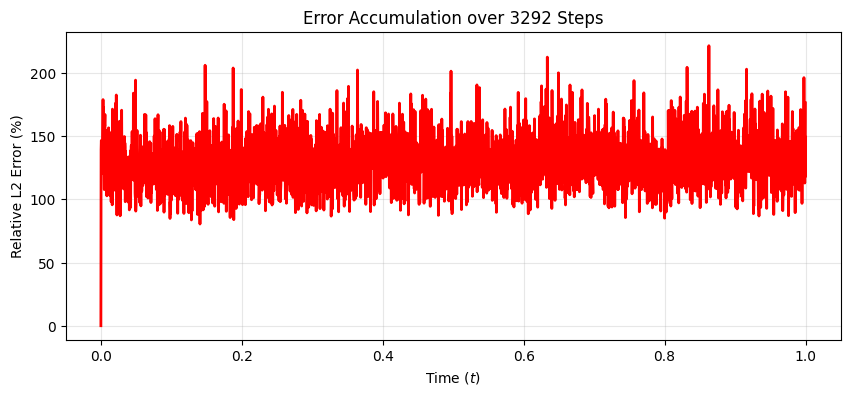

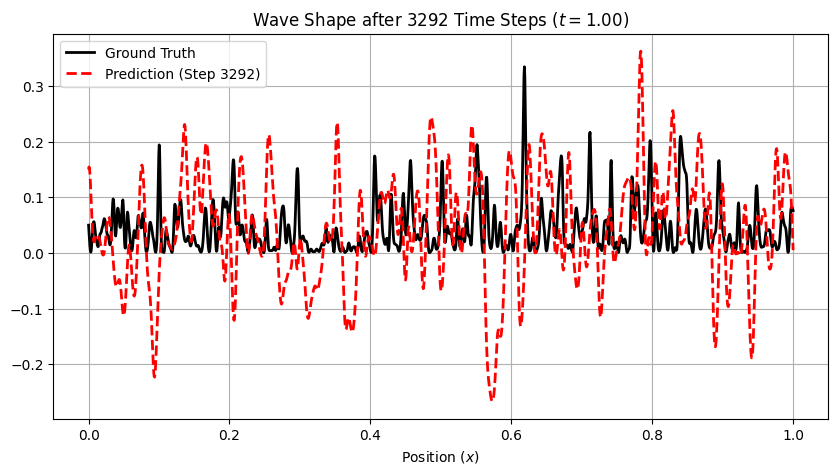

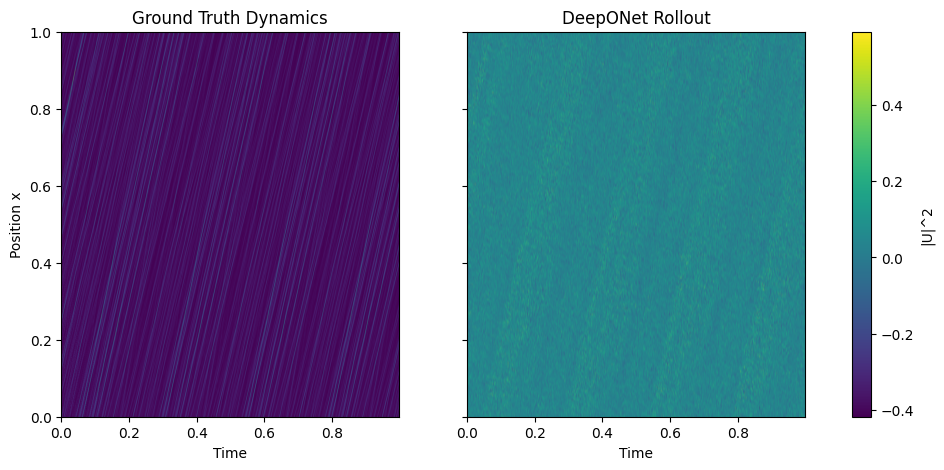

In [35]:
# --- 3. VISUALIZATION ---

# Plot A: Error Accumulation over Time
plt.figure(figsize=(10, 4))
plt.plot(t_rollout, errors_rollout * 100, 'r-', linewidth=2)
plt.title(f"Error Accumulation over {ROLLOUT_STEPS} Steps")
plt.xlabel("Time ($t$)")
plt.ylabel("Relative L2 Error (%)")
plt.grid(True, alpha=0.3)
plt.show()

# Plot B: Spatial Snapshot Comparison (Last Step of Rollout)
# Compares the final simulated frame vs truth
last_idx = -1 
plt.figure(figsize=(10, 5))
plt.plot(x_test_grid, true_rollout[last_idx], 'k-', linewidth=2, label="Ground Truth")
plt.plot(x_test_grid, pred_rollout[last_idx], 'r--', linewidth=2, label=f"Prediction (Step {ROLLOUT_STEPS})")
plt.title(f"Wave Shape after {ROLLOUT_STEPS} Time Steps ($t={t_rollout[last_idx]:.2f}$)")
plt.xlabel("Position ($x$)")
plt.legend()
plt.grid(True)
plt.show()

# Plot C: Spatiotemporal Heatmap (Optional but Recommended)
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Truth
ax[0].imshow(true_rollout.T, aspect='auto', origin='lower', extent=[t_rollout[0], t_rollout[-1], x_test_grid[0], x_test_grid[-1]])
ax[0].set_title("Ground Truth Dynamics")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Position x")

# Prediction
im = ax[1].imshow(pred_rollout.T, aspect='auto', origin='lower', extent=[t_rollout[0], t_rollout[-1], x_test_grid[0], x_test_grid[-1]])
ax[1].set_title("DeepONet Rollout")
ax[1].set_xlabel("Time")

plt.colorbar(im, ax=ax, label="|U|^2")
plt.show()